In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.Optimizer import BayesianOptimization
from src.Utils import rosenbrock, rbf_kernel

In [2]:
n_total_evaluations = 10
n_warmup = 5
limits = [(0.5,1.15), (0.5,1.5)]
opt = BayesianOptimization(kernel=rbf_kernel, 
                           optimization_function=rosenbrock,
                           limits=limits)
res = opt.optimize(N_warmup=n_warmup,N_optimize=n_total_evaluations-n_warmup)
res

{'x': array([0.5, 0.5]), 'y': 0.5}

In [3]:
y = opt.gaussian_process.sample_values

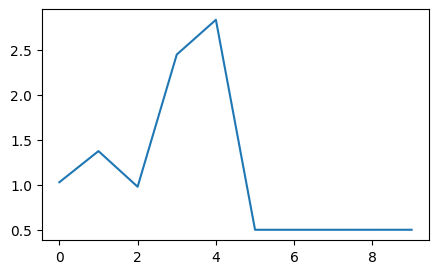

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
n = [_ for _ in range(len(y))]
ax.plot(n,y)
plt.show()